### Building a probabilistic rating system for the sports version of “What? Where? When?" (ChGK)

Background: in the sports version of “What? Where? When?” competing teams answer the same questions. After a minute of discussion, the teams write down and hand over their answers on cards; the winner is the one who answered the most questions. The tournament usually consists of several dozen questions (usually 36 or 45, sometimes 60, more rarely). There are often synchronous tournaments when the same questions are answered by teams on hundreds of playgrounds around the world, i.e. hundreds or even thousands of teams can play in one tournament. Accordingly, we need:


*   build a rating list that is able to non-trivially predict the results of future tournaments;
*   at the same time, since ChGK is a hobby, and there are no contracts here, players constantly move from team to team, a strong player can play for another team for one tournament, etc.; therefore, the unit of the rating list should not be a team, but a separate player;
*   and what greatly simplifies the task and translates it into the field of homework for the EM algorithm is the nature of the data: starting from some point, all the team's survey results began to be entered into the results database, i.e. there will be entries in the data like “which team answered which question correctly".


In [ ]:
import pickle
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
import gc

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Getting and parsing data

Data downoaded from https://rating.chgk.info/

In [ ]:
players = pickle.load(open("/content/drive/MyDrive/MADE/2_полугодие_MADE/Advanced_ML/hw2/players.pkl", "rb"))
results = pickle.load(open("/content/drive/MyDrive/MADE/2_полугодие_MADE/Advanced_ML/hw2/results.pkl", "rb"))
tournaments = pickle.load(open("/content/drive/MyDrive/MADE/2_полугодие_MADE/Advanced_ML/hw2/tournaments.pkl", "rb"))

In [ ]:
type(tournaments)

dict

In [ ]:
len(players), len(results), len(tournaments)

(204063, 5528, 5528)

In [ ]:
tournaments[1]

{'dateEnd': '2003-07-27T00:00:00+04:00',
 'dateStart': '2003-07-25T00:00:00+04:00',
 'id': 1,
 'name': 'Чемпионат Южного Кавказа',
 'orgcommittee': [],
 'questionQty': None,
 'season': '/seasons/1',
 'synchData': None,
 'type': {'id': 2, 'name': 'Обычный'}}

In [ ]:
tournaments_train, tournaments_test = {}, {}

for id, info in tqdm(tournaments.items()):
    if results[id] and "mask" in results[id][0]:
        if results[id][0]["mask"] is not None and len(results[id][0]["teamMembers"]) > 0:
            if info["dateStart"][:4] == "2019":
                tournaments_train[id] = info
            elif info["dateStart"][:4] == "2020":
                tournaments_test[id] = info

100%|██████████| 5528/5528 [00:00<00:00, 261779.96it/s]


In [ ]:
len(tournaments_train), len(tournaments_test)

(674, 173)



*   questionsTotal - number of correct answers
*   len(mask) - number of questions
*   'X' value in mask - canceled question
*   tournament types: "Normal" "Synchronous" and "Strictly synchronous





#### Baseline model

Let's write a function that counts the proportion of correct answers for each player.

In [ ]:
def get_player_scores(tournaments):
    player_to_correct_ans_num = defaultdict(int)
    player_to_ans_num = defaultdict(int)

    for id in tqdm(tournaments):
        for info in results[id]:
            mask = info["mask"]
            if mask != None:
                for players in info["teamMembers"]:
                    player_to_correct_ans_num[players["player"]["id"]] += mask.count('1')
                    player_to_ans_num[players["player"]["id"]] += len(mask)


    player_id_to_score = {player_id: player_to_correct_ans_num[player_id] / player_to_ans_num[player_id] for player_id in player_to_ans_num}
    return player_id_to_score

In [ ]:
player_ids_to_scores = get_player_scores(tournaments_train)

100%|██████████| 674/674 [00:00<00:00, 802.12it/s]


In [ ]:
# player_ids_to_scores

Let's write a function that considers the complexity of each question in tournament.

In [ ]:
def get_mask_array(mask):
    mask = mask.replace('X', '0')
    mask = mask.replace('?', '0')
    return list(map(lambda x: int(x), mask))

In [ ]:
def get_question_complexities(tournaments):
    tournament_to_questions_complexity = defaultdict(int)
    for id in tqdm(tournaments):
        masks = []
        try:    # Sometimes info["mask"] = None
            for info in results[id]:
                # mask = info["mask"]
                # mask_replaced = mask.replace('X', '0')
                # mask_replaced = mask_replaced.replace('?', '0')
                masks.append(get_mask_array(info["mask"]))
            if not all(list(map(lambda x: len(x) == len(masks[0]), masks))):    # mask lengths do not always match
                continue
            assert(np.array(masks).shape[0] == len(results[id]))
            question_complexity = list(map(lambda x: 1 - x / len(results[id]), np.array(masks).sum(axis=0)))
            tournament_to_questions_complexity[id] = question_complexity
        except AttributeError as a:
            continue
    return tournament_to_questions_complexity

In [ ]:
train_question_complexities = get_question_complexities(tournaments_train)

100%|██████████| 674/674 [00:04<00:00, 145.11it/s]


In [ ]:
len(train_question_complexities)

660

Let's create a dataset for logistic regression model.

In [ ]:
# train_question_complexities[4772][:5]

In [ ]:
# results[4774][0]

In [ ]:
for elem in results[4774]:
    print(elem["position"], end=" ")

1.5 1.5 3 4 5.5 5.5 7 8.5 8.5 10.5 10.5 14 14 14 14 14 19 19 19 19 19 25 25 25 25 25 25 25 31.5 31.5 31.5 31.5 31.5 31.5 36.5 36.5 36.5 36.5 42.5 42.5 42.5 42.5 42.5 42.5 42.5 42.5 49.5 49.5 49.5 49.5 49.5 49.5 55 55 55 55 55 59 59 59 63.5 63.5 63.5 63.5 63.5 63.5 68.5 68.5 68.5 68.5 73 73 73 73 73 78.5 78.5 78.5 78.5 78.5 78.5 82.5 82.5 84.5 84.5 87 87 87 89.5 89.5 

Let's create a dataset containing:

1.   player id
2.   tournament id + question id
3.   player correct answer pct
4.   complexity of the question
5.   team position
6.   number of commands
7.   answer to question





In [ ]:
dataset_array = []
for tournament_id, question_complexities in tqdm(train_question_complexities.items()):
    team_size = len(results[tournament_id])
    for info in results[tournament_id]:
        position = info["position"] / team_size
        mask = info["mask"]
        mask = get_mask_array(mask)
        for players in info["teamMembers"]:
            for i, q_complexity_array in enumerate(zip(mask, question_complexities)):
                dataset_array.append([players["player"]["id"],
                                            str(tournament_id) + "_" + str(i),
                                            player_ids_to_scores[players["player"]["id"]],
                                            q_complexity_array[1],
                                            position,
                                            team_size,
                                            q_complexity_array[0]])

100%|██████████| 660/660 [00:55<00:00, 11.80it/s]


In [ ]:
len(question_complexities)

36

In [ ]:
len(dataset_array)

16215179

In [ ]:
for tournament_id, question_complexities in train_question_complexities.items():
    print(tournament_id, question_complexities)
    break

4772 [0.11688311688311692, 0.22077922077922074, 0.5541125541125541, 0.48051948051948057, 0.12121212121212122, 0.17748917748917747, 0.17748917748917747, 0.8051948051948052, 0.8008658008658008, 0.9696969696969697, 0.16883116883116878, 0.48484848484848486, 0.025974025974025983, 0.5064935064935066, 0.5411255411255411, 0.16883116883116878, 0.5238095238095238, 0.4458874458874459, 0.6580086580086579, 0.961038961038961, 0.11688311688311692, 0.6017316017316017, 0.5584415584415585, 0.4285714285714286, 0.9177489177489178, 0.7099567099567099, 0.316017316017316, 0.9523809523809523, 0.961038961038961, 0.32900432900432897, 0.6493506493506493, 0.5584415584415585, 0.6753246753246753, 0.8528138528138528, 0.7445887445887446, 0.9307359307359307]


An attempt to make a pd DataFrame failed due to lack of RAM :) But there is a life hack

In [ ]:
# players_df = pd.DataFrame(dataset_array, 
#                           columns=["id", "tour_&_quest_id", "player_score", "quest_compl", "team_pos", "team_size", "answer"]).astype({"id": "int", 
#                                                                                                                                        "tour_&_quest_id": "object",
#                                                                                                                                        "player_score": "float", 
#                                                                                                                                        "quest_compl": "float", 
#                                                                                                                                        "team_pos": "int",
#                                                                                                                                        "team_size": "float",
#                                                                                                                                        "answer": "int"})

In [ ]:
part_len = len(dataset_array) // 10

players_df = pd.DataFrame(dataset_array[:part_len], 
                          columns=["id", "tour_&_quest_id", "player_score", "quest_compl", "team_pos", "team_size", "answer"]).astype({"id": "int", 
                                                                                                                                       "tour_&_quest_id": "object",
                                                                                                                                       "player_score": "float", 
                                                                                                                                       "quest_compl": "float", 
                                                                                                                                       "team_pos": "float",
                                                                                                                                       "team_size": "float",
                                                                                                                                       "answer": "float"})
dataset_array = dataset_array[part_len:]

for _ in tqdm(range(10)):
    new_df = pd.DataFrame(dataset_array[:part_len], 
                          columns=["id", "tour_&_quest_id", "player_score", "quest_compl", "team_pos", "team_size", "answer"]).astype({"id": "int", 
                                                                                                                                       "tour_&_quest_id": "object",
                                                                                                                                       "player_score": "float", 
                                                                                                                                       "quest_compl": "float", 
                                                                                                                                       "team_pos": "int",
                                                                                                                                       "team_size": "float",
                                                                                                                                       "answer": "int"})
    frames = [players_df, new_df]
    players_df = pd.concat(frames)
    dataset_array = dataset_array[part_len:]

100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


In [ ]:
len(dataset_array), len(players_df)

(0, 16215179)

In [ ]:
players_df.head()

,id,tour_&_quest_id,player_score,quest_compl,team_pos,team_size,answer
0,6212,4772_0,0.706069,0.116883,0.004329,231.0,1.0
1,6212,4772_1,0.706069,0.220779,0.004329,231.0,1.0
2,6212,4772_2,0.706069,0.554113,0.004329,231.0,1.0
3,6212,4772_3,0.706069,0.480519,0.004329,231.0,1.0
4,6212,4772_4,0.706069,0.121212,0.004329,231.0,1.0


In [ ]:
del players
del results
del tournaments
gc.collect()

0

In [ ]:
players_df["team_size"] = players_df["team_size"] / players_df["team_size"].max()

In [ ]:
lr = LogisticRegression()
lr.fit(players_df.loc[:, ~players_df.columns.isin(["id", "tour_&_quest_id", "answer"])], players_df.loc[:, "answer"])

LogisticRegression()

In [ ]:
lr.score(players_df.loc[:, ~players_df.columns.isin(["id", "tour_&_quest_id", "answer"])], players_df.loc[:, "answer"])

0.7634533050791483

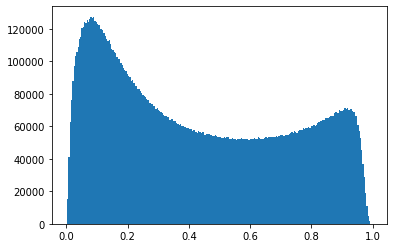

In [ ]:
predictions = lr.predict_proba(players_df.loc[:, ~players_df.columns.isin(["id", "tour_&_quest_id", "answer"])])[:, 1]
plt.hist(predictions, bins="auto")
plt.show()

#### Predicting team strength

In [ ]:
players_df.head()

,id,tour_&_quest_id,player_score,quest_compl,team_pos,team_size,answer
0,6212,4772_0,0.706069,0.116883,0.004329,0.189655,1.0
1,6212,4772_1,0.706069,0.220779,0.004329,0.189655,1.0
2,6212,4772_2,0.706069,0.554113,0.004329,0.189655,1.0
3,6212,4772_3,0.706069,0.480519,0.004329,0.189655,1.0
4,6212,4772_4,0.706069,0.121212,0.004329,0.189655,1.0


In [ ]:
player_id_to_pred_df = players_df.loc[:, ["id"]]
player_id_to_pred_df["prob"] = predictions
player_id_to_pred_dict = player_id_to_pred_df.groupby(["id"])["prob"].mean().to_dict()

In [ ]:
results = pickle.load(open("/content/drive/MyDrive/MADE/2_полугодие_MADE/Advanced_ML/hw2/results.pkl", "rb"))

In [ ]:
%%time
spearman_correlations = []
kendall_correlations = []
for id in tournaments_test:
    team_strength = []
    for info in results[id]:
        try:
            team_strength.append(np.mean(list(map(lambda x: player_id_to_pred_dict[x["player"]["id"]], info["teamMembers"]))))
        except KeyError:
            continue
    team_strength_argsorted = np.array(team_strength).argsort()[::-1]
    ranks = np.empty_like(team_strength_argsorted)
    ranks[team_strength_argsorted] = np.arange(1, len(team_strength) + 1)
    spearman_corr = spearmanr(range(1, len(team_strength) + 1), ranks)[0]
    kendall_corr = kendalltau(range(1, len(team_strength) + 1), ranks)[0]
    if not np.isnan(spearman_corr):
        spearman_correlations.append(spearman_corr)
    if not np.isnan(kendall_corr):
        kendall_correlations.append(kendall_corr)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 582 ms, sys: 3.7 ms, total: 586 ms
Wall time: 591 ms


In [ ]:
np.mean(spearman_correlations), np.mean(kendall_correlations)

(0.6324967865623593, 0.47618407014003)

#### EM algorithm